# Single Neuron Convolution Modeling:
(written by Amanda Ray for the publication "Nonlinear integration of sensory inputs and behavioral state by a single neuron in C. elegans" doi: https://doi.org/10.1101/2025.04.05.647390) 

Written: 04.07.25, Last updated: 09.29.25


This code will walk through using the convolved trace of one neuron to model AIB activity. WT AVA normalized traces will be used as an example.


** Please note that I am an amateur at coding. I'm sure there are more efficient ways to code things, so please feel free to rewrite code more proficiently for your own usage! :) **

In [3]:
## Imports ##

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy
import math
import statistics
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd

In [4]:
## Importing Dictionary Datasets ##

WT_worm_num = 15

# Worm numbers for other datasets:
# WT_AWC_worm_num = 20
# nmrHis_worm_num = 20
# insHis_worm_num = 12
# strHis_worm_num = 14

# All datasets include odor, red light, and odor + red light (nicknamed 'both') experiments for each neuron.
# allow_pickle=True).item() needed for items with multiple elements (ie 2D arrays)

# AVA-AIB-AIA traces for WT worms - 15 worms #
WT_dict = np.load('WT AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(WT_dict)

# AWC traces for WT worms - 20 worms #
WT_AWC_dict = np.load('WT AWC.npy', allow_pickle=True).item()
#print(WT_AWC_dict)

# AVA-AIB-AIA traces for nmr-1::HisCl (motor-silenced) worms - 20 worms #
nmrHis_dict = np.load('nmr-1_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(nmrHis_dict)

# AVA-AIB-AIA traces for str-2::HisCl (AWC-silenced) worms - 14 worms #
strHis_dict = np.load('str-2_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(strHis_dict)

# AVA-AIB-AIA traces for ins-1s::HisCl (AIA-silenced) worms - 12 worms #
insHis_dict = np.load('ins-1s_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(insHis_dict)

print("Imported data successfully!")

Imported data successfully!


In [5]:
# Find and return data arrays of interest for each worm, type of trace (raw, background corrected, or normalized), 
# and experiment (odor, red light, odor+red [both]). 

def FindNeurons(dictionary, data_type, neuron_name, exp):
    
    array = []
    
    for key, value in dictionary.items(): # this loops through worms and types of traces
        for key2, value2 in value.items(): # for each worm, loops through the types of data to get arrays
            if data_type in key and neuron_name in key2 and exp in key2:
                array.append(value2)
                
    if not array: # Check if correct array exists, otherwise will be empty
        print("Error! Does not exist! Make sure you are in correct dictionary and using correct keywords!")
    else:       
        return array


# Pull out full set of experiments for AIB and AVA - just showing WT for simplicity
# We will use normalized data

# WT #
WT_AIB_odor = FindNeurons(WT_dict, "Norm", "AIB", "Odor")
WT_AIB_red = FindNeurons(WT_dict, "Norm", "AIB", "Red")
WT_AIB_both = FindNeurons(WT_dict, "Norm", "AIB", "Both")

WT_AVA_odor = FindNeurons(WT_dict, "Norm", "AVA", "Odor")
WT_AVA_red = FindNeurons(WT_dict, "Norm", "AVA", "Red")
WT_AVA_both = FindNeurons(WT_dict, "Norm", "AVA", "Both")

print('Done')

Done


In [6]:
## - Model AIB data by convolving with a single neuron - ##

# Method uses downhill simplex method (Nelder-Mead) via scipy optimize to find the smallest residual between 
# model and real AIB. Need to seed the function first with some parameters (params) to help find optimum solution. 
# Can let all kernel parameters (amplitude, alpha1, alpha2) float, or fix alpha values (fixed_or_float) for modeling.
# If choose 'fixed', then input alpha1 and alpha2 values of your choosing, and just seed with a number for amplitude.
# Otherwise if 'float', model will optimize all parameters you seed it with.

def Convolution_OneNeuron(AIB, neuron, params, fixed_or_float, alpha1_input, alpha2_input, worm_num):
    time = 250 # kernel time window, we found 250 frames to be a good time period
    t = np.arange(0, time)
    
    models = [] 
    amps = []
    alpha1 = []
    alpha2 = []
    res = [] 
    
    def Model(neuron, params):
        if fixed_or_float == 'fixed': #establish alpha parameters with fixed values, only amplitudes optimized
            k = params[0] * (np.exp(-alpha1_input*t) - np.exp(-alpha2_input*t))
        else:
            k = params[0] * (np.exp(-params[1]*t) - np.exp(-params[2]*t)) #otherwise, let all be optimized
            
        model = np.convolve(neuron, k,'valid') 
        # 'valid' method produces convolution where the beginning of the original trace is lost.
        # Loss is calculated by time window used (250) minus 1, so that resulting model is 249 frames less than 
        # original. This becomes important for plotting later to properly align model with original traces.
        # See numpy.convolve documentation for explanation of other options, but 'valid' was chosen because it
        # convolves same-size arrays only where they completely overlap.
        
        return model
        
    for i in range(worm_num):
        #print('Worm #: ', i)
        def Res(params):
            model_AIB = Model(neuron[i], params)
            
            loss = time - 1 # this is from convolution loss (see comment above)
            # to align real AIB with model, we have to cut off the loss in the beginning of the real trace
            # (AIB[i][loss:])
            
            # Residual:
            # take difference of real vs model AIB, square it, divide it by number of frames, then take square root
            Residual = np.sqrt(np.sum(np.subtract(AIB[i][loss:],model_AIB)**2) / len(model_AIB))
            return Residual

        optimize = minimize(Res, params, method='Nelder-Mead') # optimizing for smallest solution (residual)
        res.append(optimize['fun']) # want to save resulting residual
        parameters_new = optimize['x'] # final new parameters based on optimization
        new_model = Model(neuron[i], parameters_new) # use these new optimized parameters to model AIB
        models.append(new_model) # save resulting model
        amps.append(parameters_new[0]) # save resulting optimized amplitude (first parameter)
        if fixed_or_float == 'float': # if allowed to float, save the alpha values also (second and third parameter)
            alpha1.append(parameters_new[1])
            alpha2.append(parameters_new[2])
       
    return res, models, amps, alpha1, alpha2

p1 = [1, 0.01, 0.05] # parameters used for seeding initial optimization. order = [amplitude, alpha1, alpha2]
# These were determined through a series of tests. Seeded values too far off can sometimes result in the 
# model getting stuck in local minima. Feel free to try others. AIA works well with more negative amplitudes,
# and I used [-1, 0.01, 0.05] to seed AIA-only model params.

# Note: for AWC-only modeling, I used the averaged AWC trace. Details will be explained in later block 
# of code below.

# I will only show AVA-only modeling here.

WT_worm_num = 15

## WT - AVA only ##
WT_AVA_conv_odor = Convolution_OneNeuron(WT_AIB_odor, WT_AVA_odor, p1, 'float', 0, 0, WT_worm_num)
WT_AVA_odor_res = WT_AVA_conv_odor[0]
WT_AVA_odor_model = WT_AVA_conv_odor[1] 
WT_AVA_odor_amps = WT_AVA_conv_odor[2]
WT_AVA_odor_alpha1 = WT_AVA_conv_odor[3]
WT_AVA_odor_alpha2 = WT_AVA_conv_odor[4]

WT_AVA_conv_red = Convolution_OneNeuron(WT_AIB_red, WT_AVA_red, p1, 'float', 0, 0, WT_worm_num)
WT_AVA_red_res = WT_AVA_conv_red[0]
WT_AVA_red_model = WT_AVA_conv_red[1] 
WT_AVA_red_amps = WT_AVA_conv_red[2]
WT_AVA_red_alpha1 = WT_AVA_conv_red[3]
WT_AVA_red_alpha2 = WT_AVA_conv_red[4]

WT_AVA_conv_both = Convolution_OneNeuron(WT_AIB_both, WT_AVA_both, p1, 'float', 0, 0, WT_worm_num)
WT_AVA_both_res = WT_AVA_conv_both[0]
WT_AVA_both_model = WT_AVA_conv_both[1] 
WT_AVA_both_amps = WT_AVA_conv_both[2]
WT_AVA_both_alpha1 = WT_AVA_conv_both[3]
WT_AVA_both_alpha2 = WT_AVA_conv_both[4]

# Due to similarity of alpha values between worms (see below for plots), use the same median value for all 
# subsequent modeling. Due to similarity between these median values, we just use the 'both' values for ease,
# since most of our subsequent modeling dealt with using 'both' experiments where AWC and AIA are stimulated.
# But if you want to be specific, others are provided.

WT_AVA_med_alpha1_odor = np.median(WT_AVA_odor_alpha1)
WT_AVA_med_alpha1_red = np.median(WT_AVA_red_alpha1)
WT_AVA_med_alpha1_both = np.median(WT_AVA_both_alpha1)

WT_AVA_med_alpha2_odor = np.median(WT_AVA_odor_alpha2)
WT_AVA_med_alpha2_red = np.median(WT_AVA_red_alpha2)
WT_AVA_med_alpha2_both = np.median(WT_AVA_both_alpha2)

print('Done')

Done


In [56]:
## - For AWC-only modeling - ##

# NOTE: Since AWC recordings were performed in a separate worm and do not correlate with the same worm recordings
# with AVA-AIB-AIA worms, we will actually use the averaged traces of AWC for each experiment as a representative
# of AWC activity for modeling. Then we're going to duplicate it to make looping through easier for modeling. 
# This is useful mostly for being able to switch the order of AWC during ignoring and silencing exps in later codes.
# I duplicated it by 20 because that's the largest number of worms I have in the datasets (nmr-1::HisCl = 20)

WT_AWC_odor = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Odor")
WT_AWC_red = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Red")
WT_AWC_both = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Both")

WT_AWC_odor_avg = np.mean(WT_AWC_odor, axis=0)
WT_AWC_red_avg = np.mean(WT_AWC_red, axis=0)
WT_AWC_both_avg = np.mean(WT_AWC_both, axis=0)

WT_AWC_odor_avg = [WT_AWC_odor_avg]*20 
WT_AWC_red_avg = [WT_AWC_red_avg]*20
WT_AWC_both_avg = [WT_AWC_both_avg]*20

In [7]:
## For subsequent modeling, you will need to save and use the obtained parameters from this model.
# You will need the median alpha values for AVA-only modeling to use for the rest of the kernels.

WT_AVA_only_params = {'Alpha1 Odor':WT_AVA_med_alpha1_odor, 'Alpha1 Red': WT_AVA_med_alpha1_red,
                      'Alpha1 Both': WT_AVA_med_alpha1_both, 'Alpha2 Odor':WT_AVA_med_alpha2_odor, 
                      'Alpha2 Red': WT_AVA_med_alpha2_red, 'Alpha2 Both': WT_AVA_med_alpha2_both}                                                

np.save('WT AVA Only Param Medians.npy', WT_AVA_only_params)

# We will also save residuals and amps for comparison later
WT_AVA_only_res = {'Residual Odor':WT_AVA_odor_res, 'Residual Red': WT_AVA_red_res,
                      'Residual Both': WT_AVA_both_res}

np.save('WT AVA Only Residuals.npy', WT_AVA_only_res)


WT_AVA_only_amps = {'Amps Odor':WT_AVA_odor_amps, 'Amps Red': WT_AVA_red_amps,
                      'Amps Both': WT_AVA_both_amps}                                                

np.save('WT AVA Only Amps.npy', WT_AVA_only_amps)


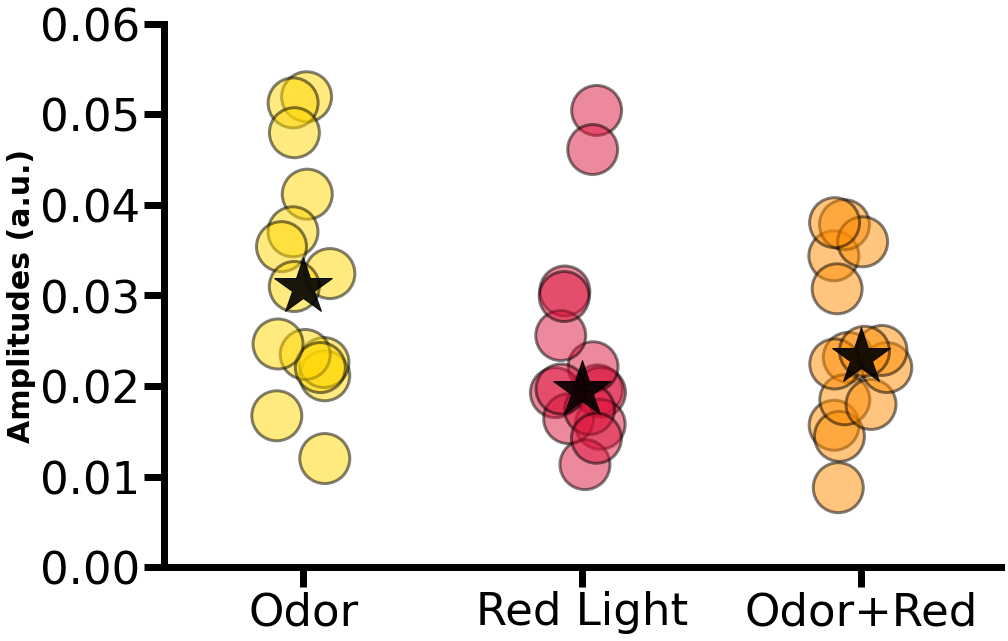

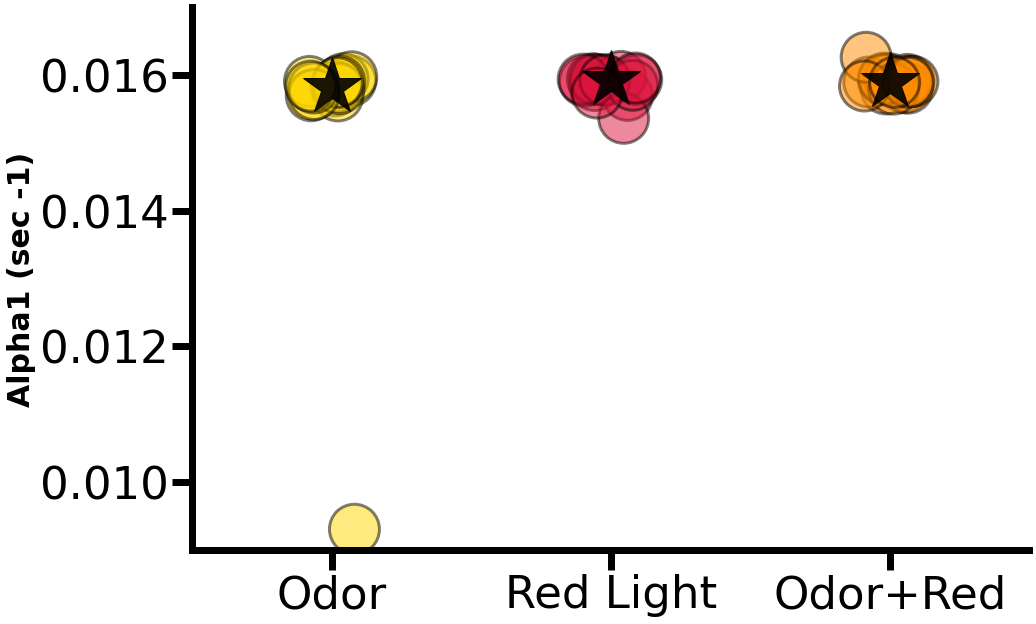

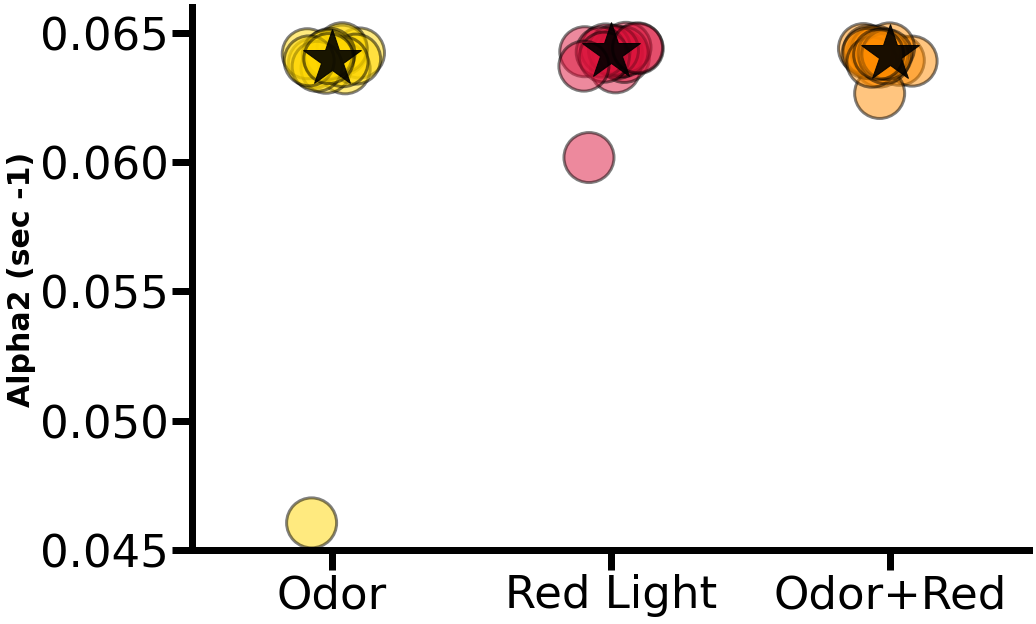

In [16]:
# This is to plot the single-neuron parameters, in this case I used AVA-only modeling to replicate sup fig 2.

def PlotParams(odor, red, both, ylim, ylabel, savename): # if you want to save file, change savename
    
    med_odor = np.median(odor)
    med_red = np.median(red)
    med_both = np.median(both)
    
    medians = [med_odor, med_red, med_both]
    
    exp_labels = ['Odor', 'Red Light', 'Odor+Red']
    colors = ['gold', 'crimson', 'darkorange']
    
    dF = pd.DataFrame(np.array([odor, red, both]).T, columns=exp_labels)

    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w') 
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    sns.stripplot(data=dF, palette=colors, edgecolor= 'black', linewidth=3, size=50, alpha = 0.5, zorder=1)
    ax.plot('Odor', med_odor, '*', markersize = 60, c = 'black', alpha = 0.9, zorder=2)
    ax.plot('Red Light', med_red, '*', markersize = 60, c = 'black', alpha = 0.9, zorder=2)
    ax.plot('Odor+Red', med_both, '*', markersize = 60, c = 'black', alpha = 0.9, zorder=2)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 7
    ax.set_ylabel(ylabel, fontsize=30, weight='bold')
    ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
    #plt.xticks(rotation=45)
    ax.set_ylim(ylim)
    ax.set_xlim([-0.5, 2.5])
    if savename != 'BLANK':
        plt.savefig(savename)
 

## WT ##
# Note: ylim values are just what I used in the paper. Feel free to change.
# Change 'BLANK' to whatever savefile name and format you want.
WT_AVA_plot_amps = PlotParams(WT_AVA_odor_amps, WT_AVA_red_amps, WT_AVA_both_amps, [0,0.06], 'Amplitudes (a.u.)', 'BLANK')
WT_AVA_plot_alpha1 = PlotParams(WT_AVA_odor_alpha1, WT_AVA_red_alpha1, WT_AVA_both_alpha1, [0.009,0.017], 'Alpha1 (sec -1)', 'BLANK')
WT_AVA_plot_alpha2 = PlotParams(WT_AVA_odor_alpha2, WT_AVA_red_alpha2, WT_AVA_both_alpha2, [0.045,0.066], 'Alpha2 (sec -1)', 'BLANK')


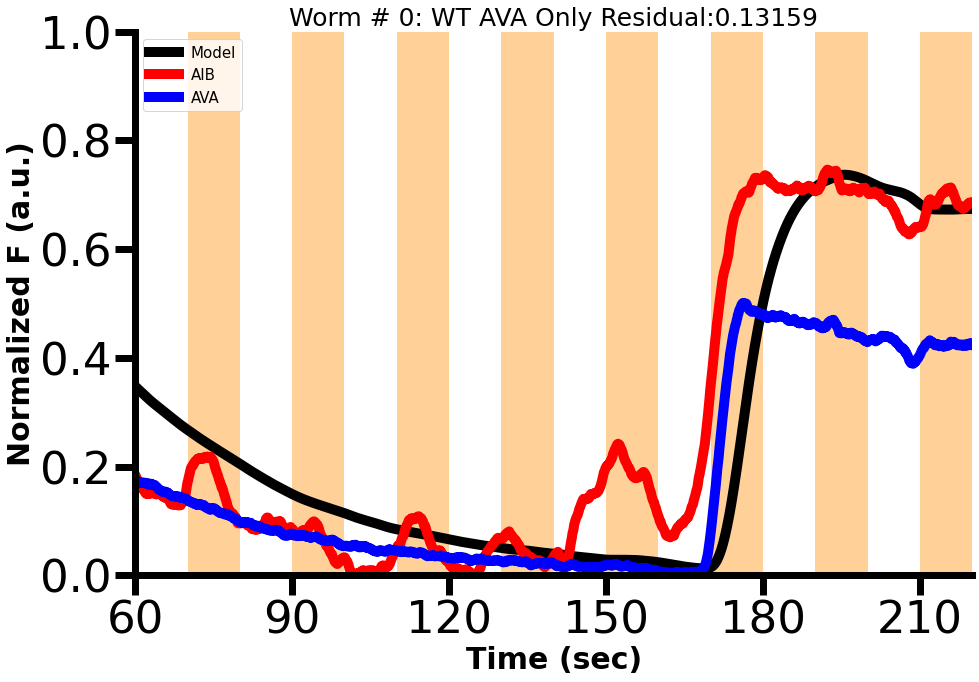

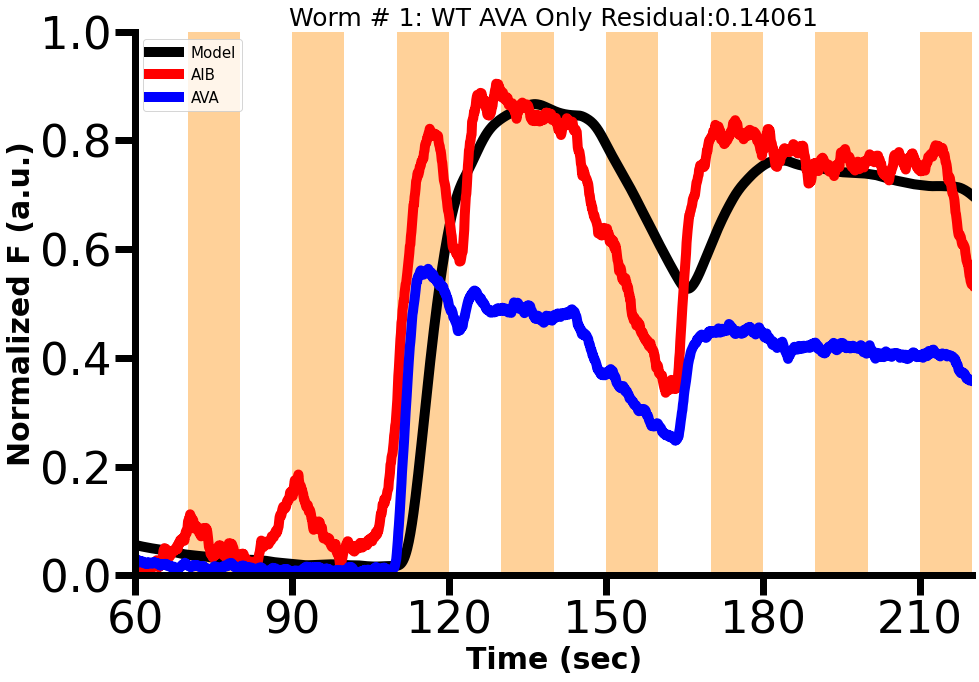

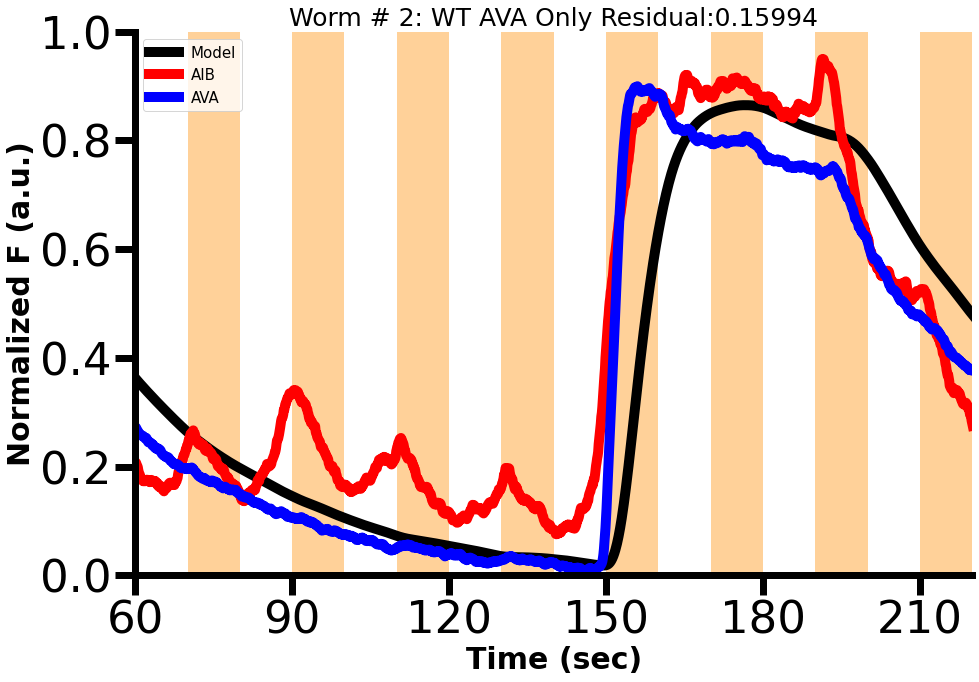

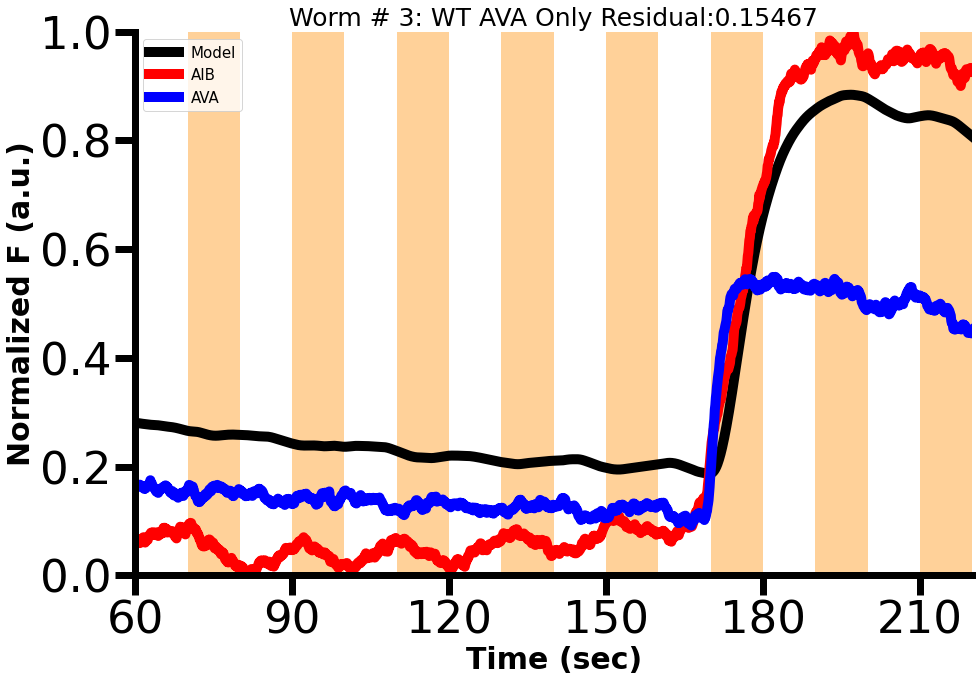

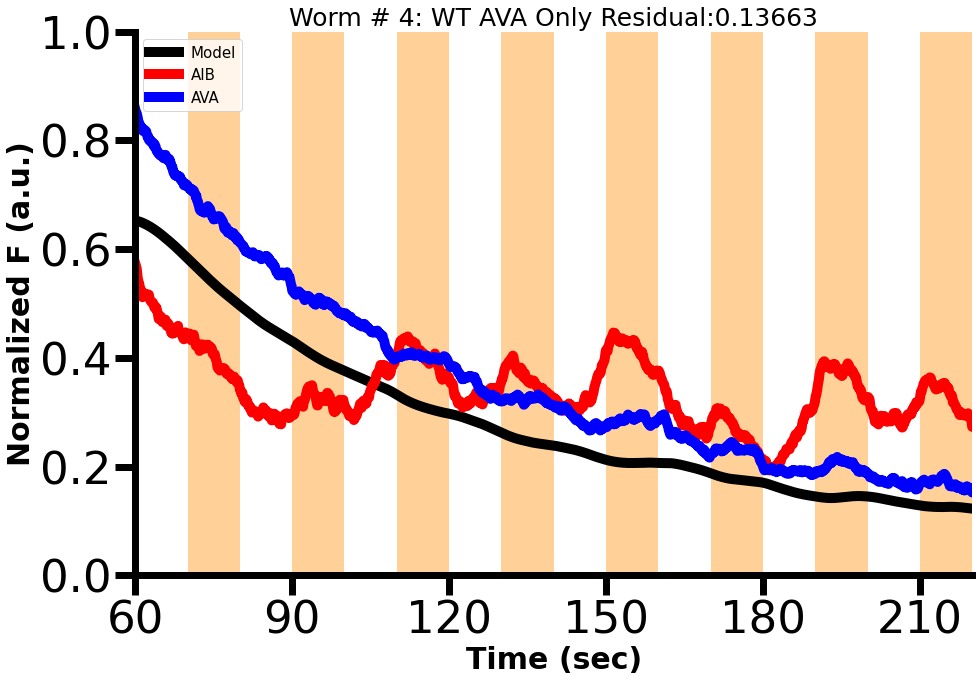

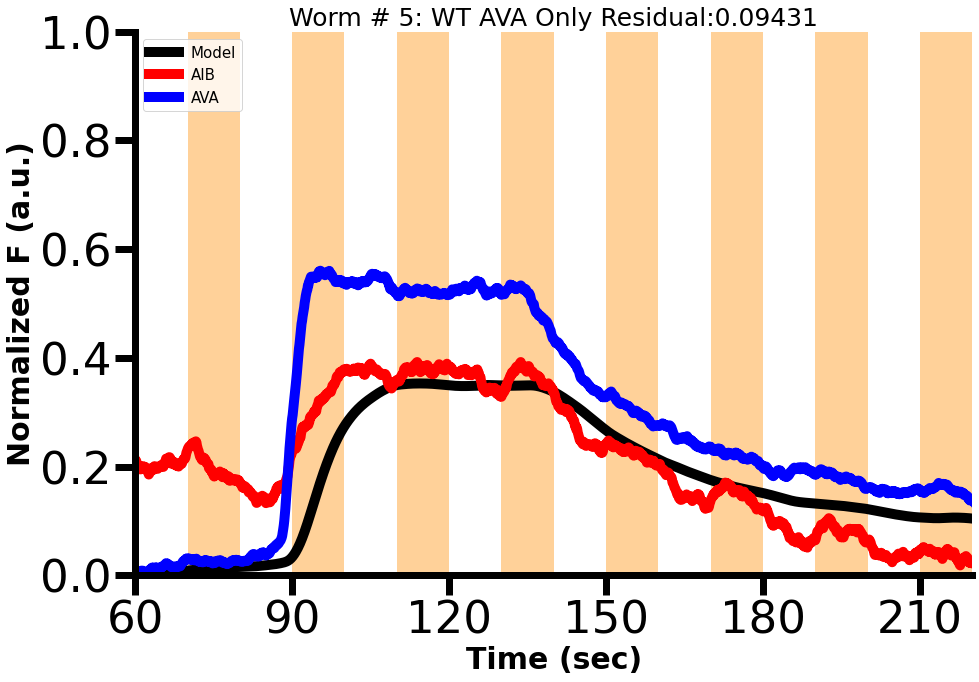

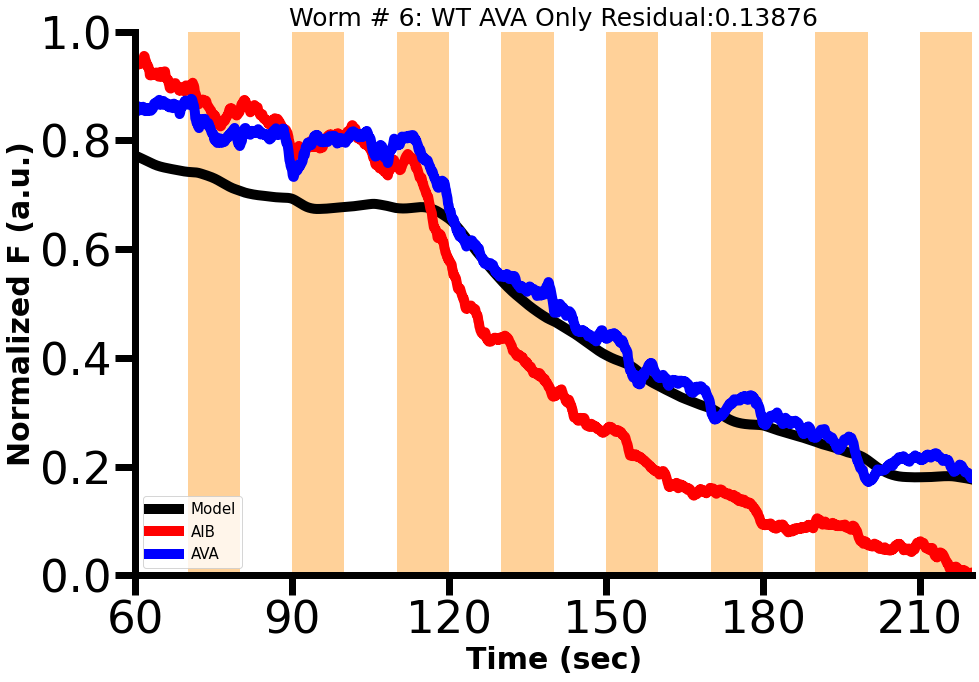

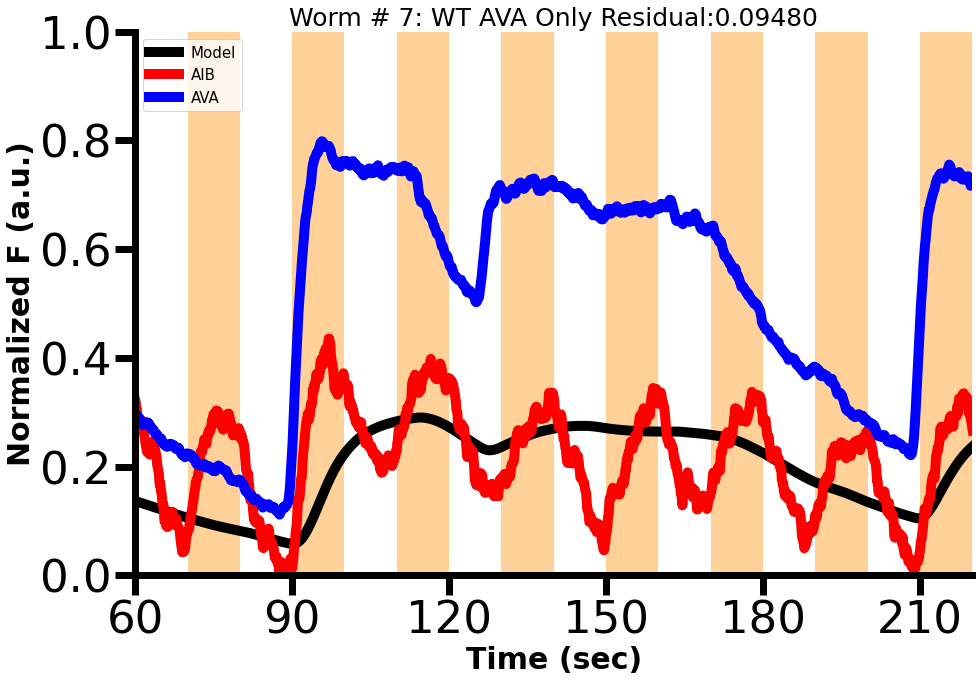

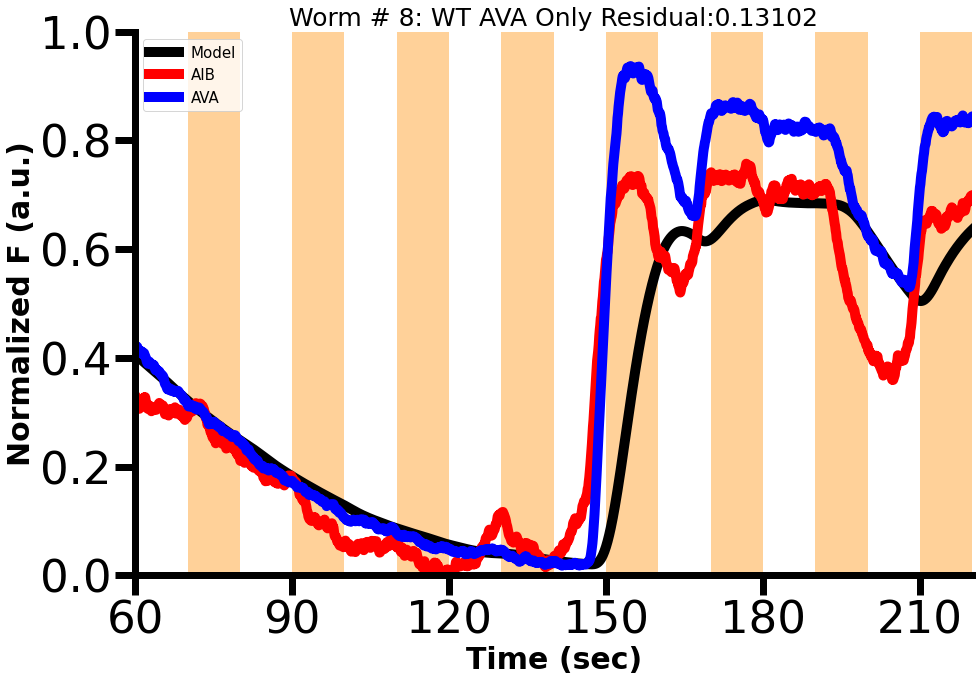

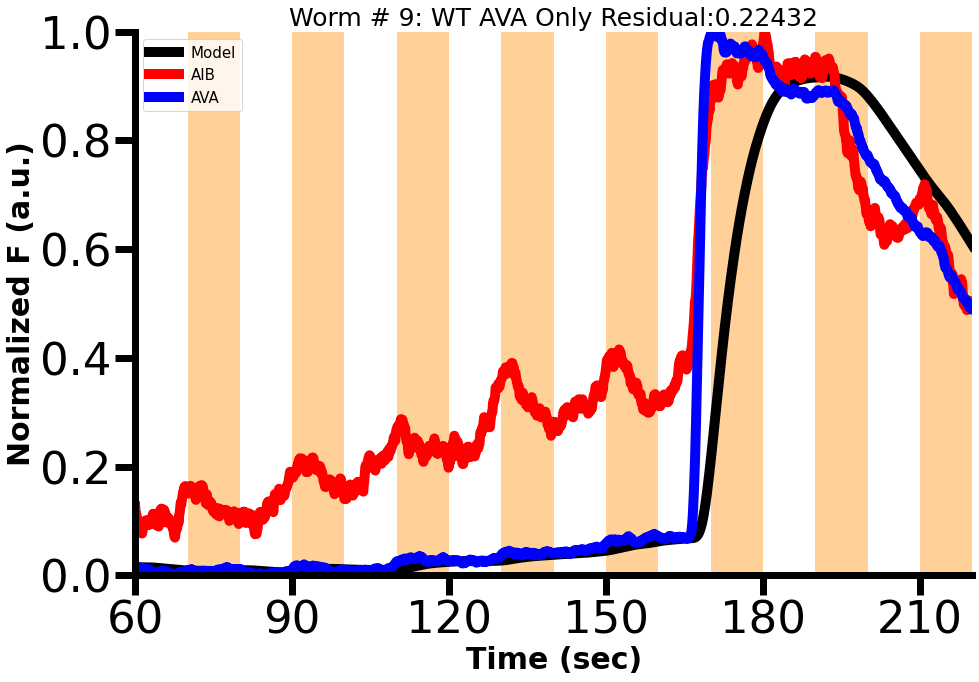

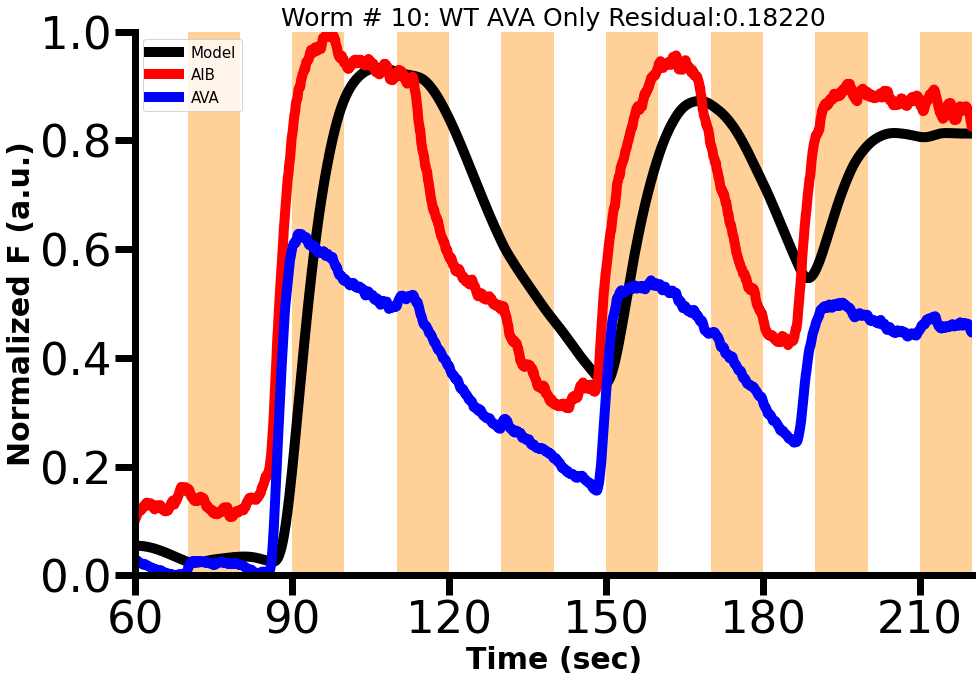

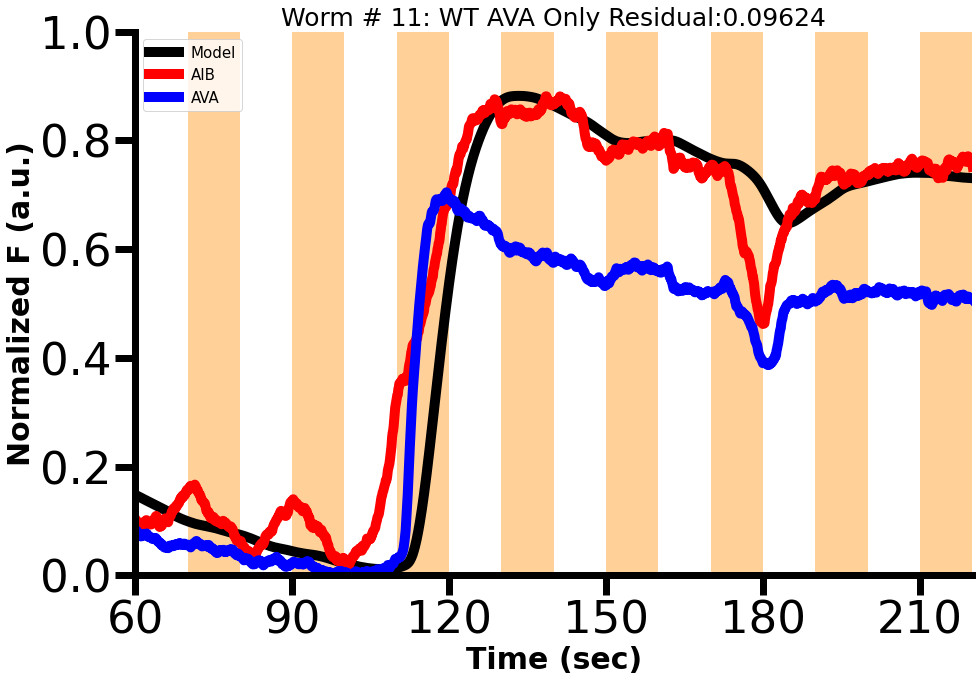

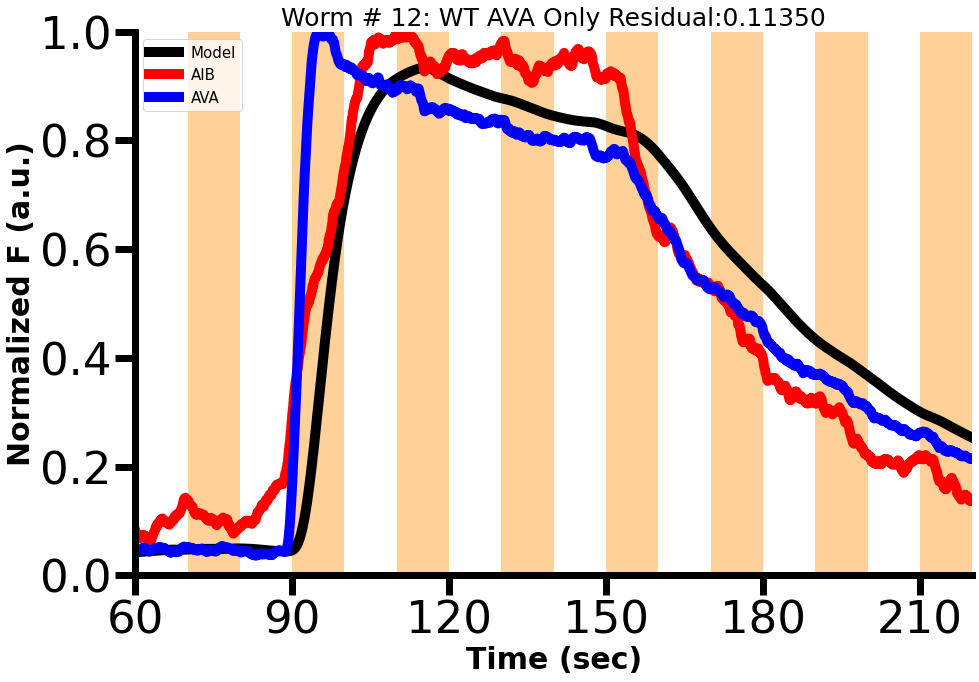

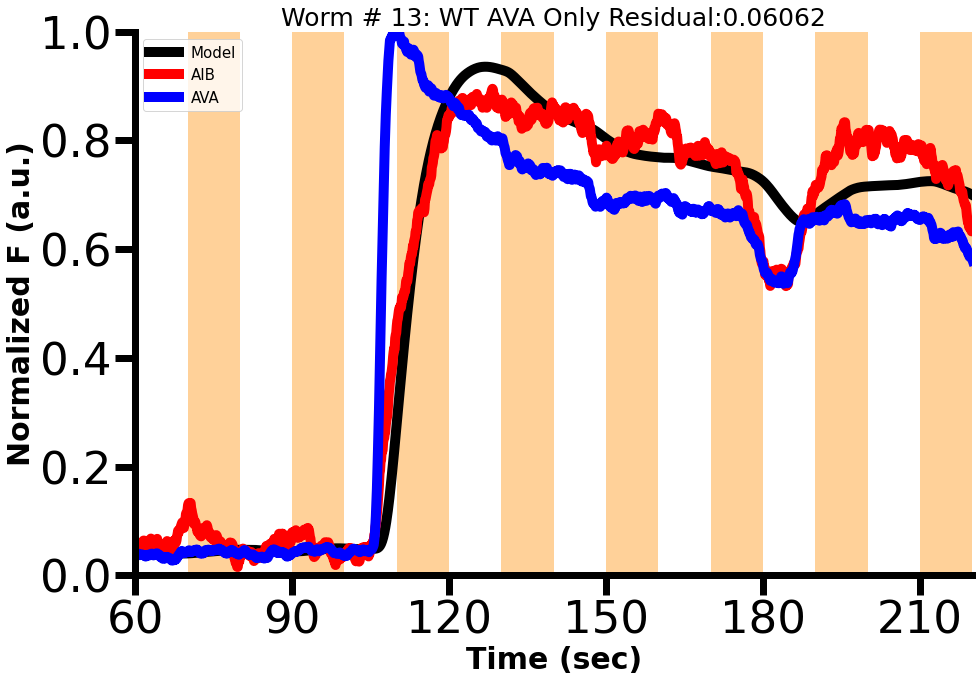

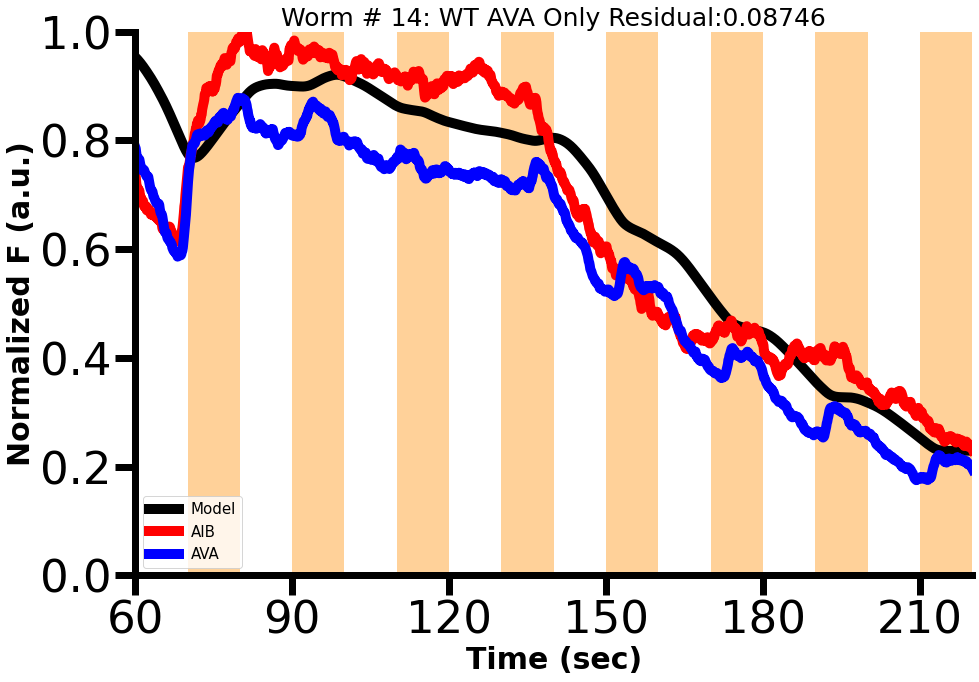

In [126]:
## - Plotting Traces and Model - ##
# Will just show odor+red light experiments as examples. 
# Note that when plotting normalized neuron traces with model, that the modeling process cuts off the first
# 249 frames, so to align neuron traces with model trace, need to cut off neuron trace AIB[249:]

# Worm #2 is what's shown in the paper figures. 

# Easier to change between worms/exps this way
worm_num = WT_worm_num # see second block of code for other worm dataset numbers
residual_plot = WT_AVA_both_res
model_plot = WT_AVA_both_model
aib_plot = WT_AIB_both 
ava_plot = WT_AVA_both
title_name = 'WT AVA Only'


# This is to plot in seconds (10 fps). Sort of complicated, but normalization cuts off 350 frames in beginning, 
# and convolution process cuts off an additional 249 frames (time window - 1) in beginning, totaling 599 frames. 
# I rounded it up to 600, and added the extra 1 frame shift to the end for simplicity, because I cut off the
# last 90 frames. There is originally a total of 2300 frames, but the smoothing process (5 frames x2) cuts off 10,
# so new length is 2290 (plus the 1 extra frame shift I added to help round the beginning). Thus, 600,2291.
# This is all just for publication and for transparency of where the ACTUAL time starts in my raw traces.
# Feel free to change to time that makes more sense lol :) 

timeplot = []
for t in range(600,2291): 
    temp = t/10
    timeplot.append(temp)

for i in range(worm_num):
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w') 
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 7
    ax.set_title('Worm # '+str(i) + ': '+ title_name + ' Residual:'+str(residual_plot[i])[:7], fontsize=25)
    ax.plot(timeplot, model_plot[i], color = 'black', linewidth=10, label='Model')
    ax.plot(timeplot, aib_plot[i][249:], color = 'red', linewidth=10, alpha=1, label='AIB') 
    ax.plot(timeplot, ava_plot[i][249:], color = 'blue', linewidth=10, alpha=1, label='AVA') 
    ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
    ax.set_ylabel('Normalized F (a.u.)', fontsize=30, weight='bold')
    ax.set_xlabel('Time (sec)', fontsize=30, weight='bold')
    ax.set_ylim([0,1])
    ax.set_xlim([60,220]) # again this is just to line up with the real time, and not artifically start at 0
    ax.legend(loc='best', fontsize=15)
    plt.xticks(np.arange(60, 220, step=30))
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        
    # If you want to color-code stimuli delivery times, use code below or comment out if don't want
    
    for j in range(22): 
        if j % 2 != 0:
            start = j*10
            stop = (j*10)+10
            ax.axvspan(start, stop, facecolor='darkorange', alpha=0.4) 
            ## odor_color = yellow 
            ## redlight_color = crimson 
            ## both_color = darkorange
            
    #plt.savefig(title_name + '.svg')

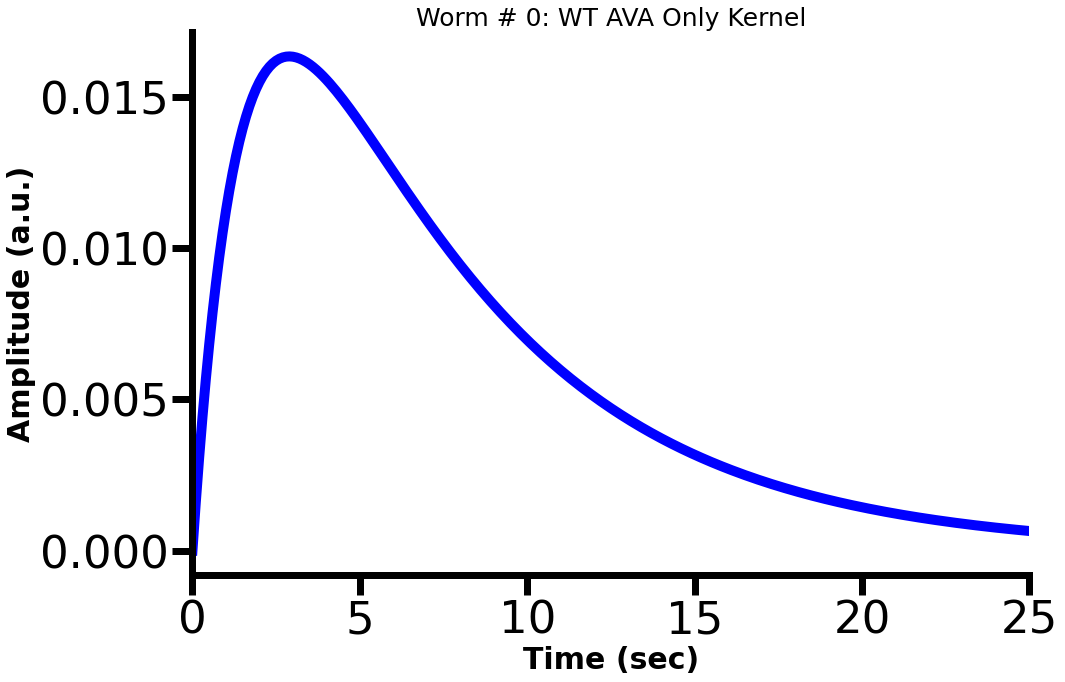

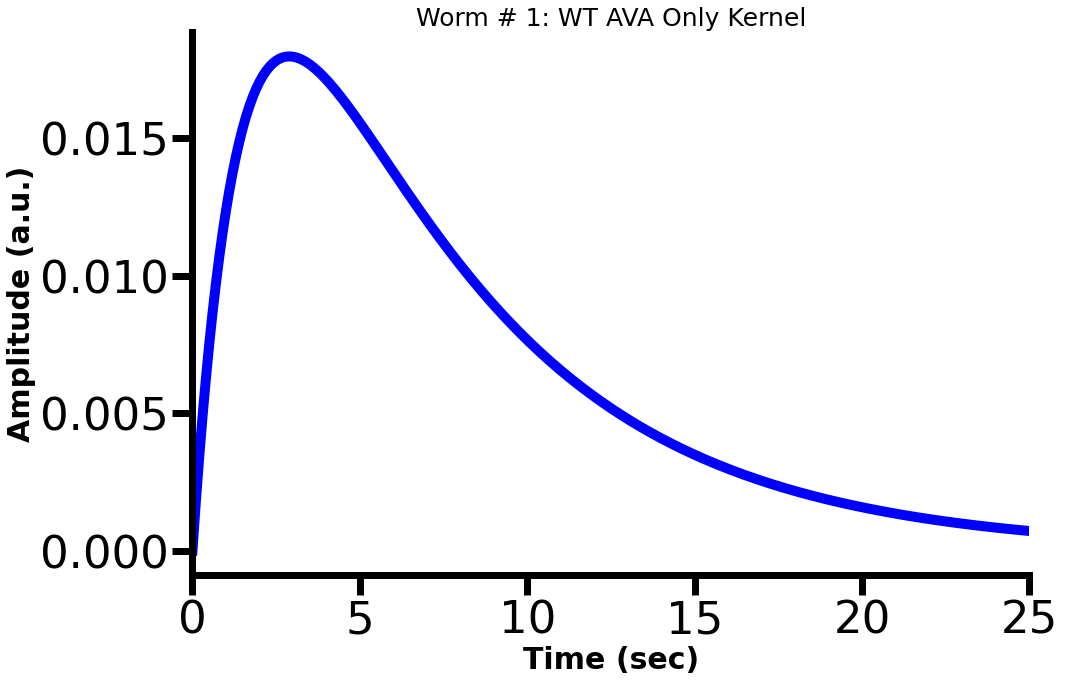

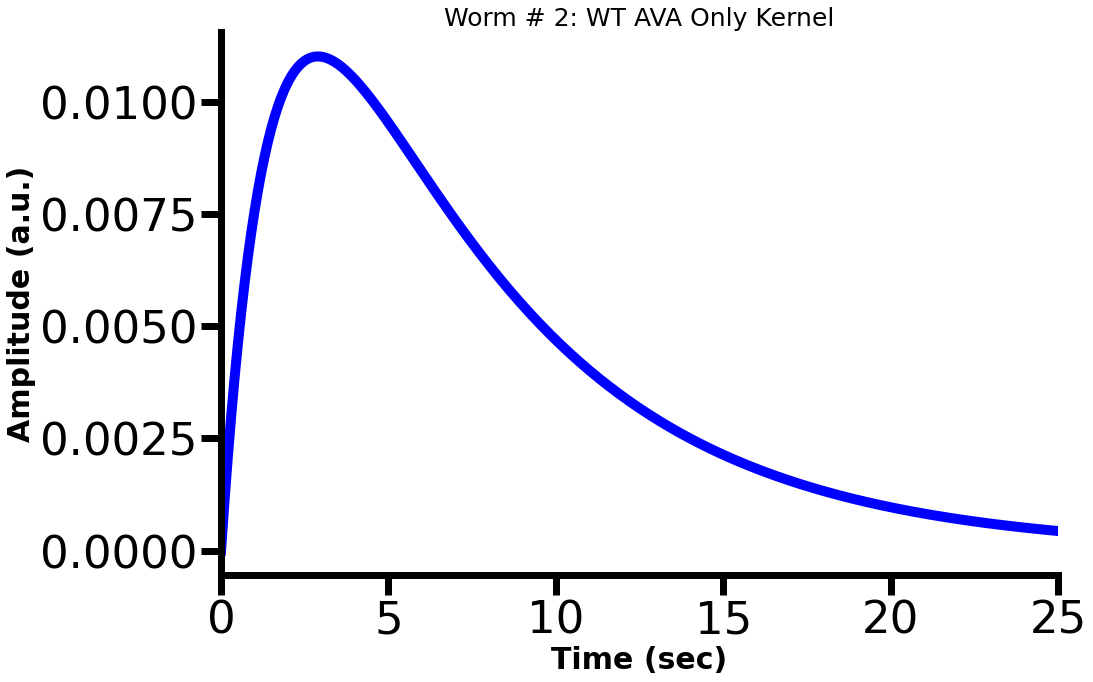

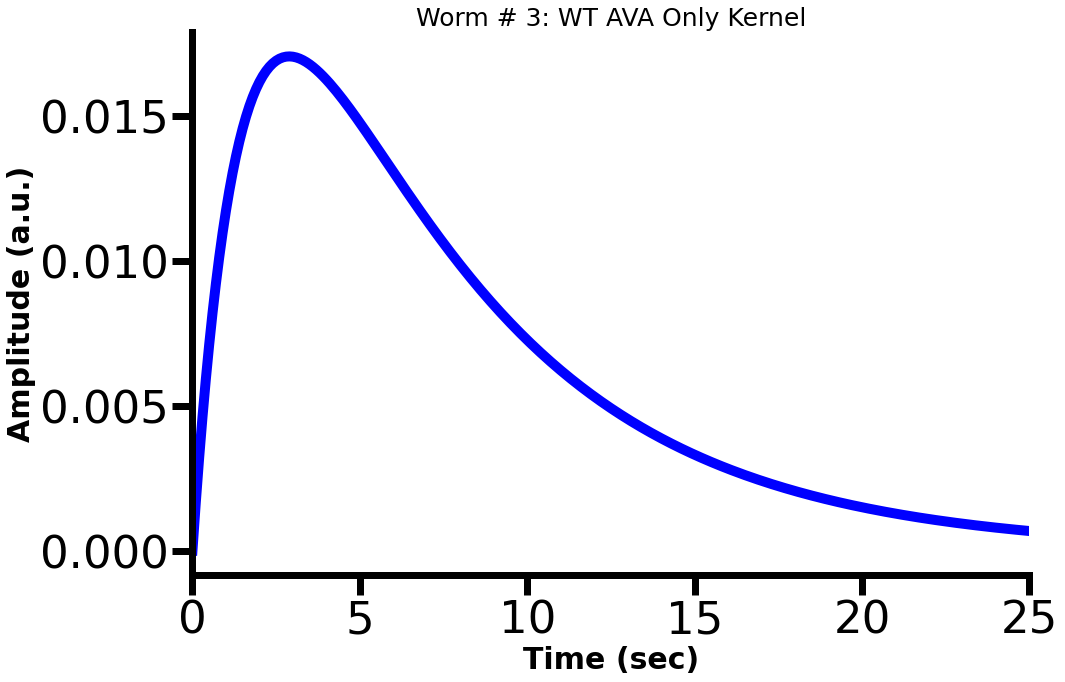

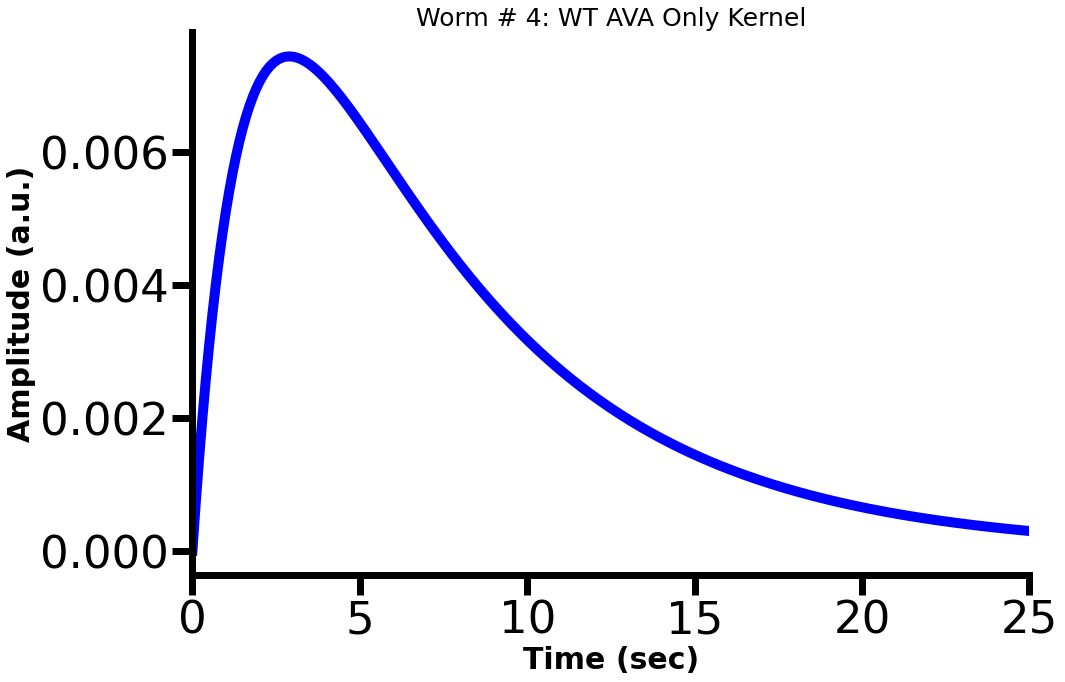

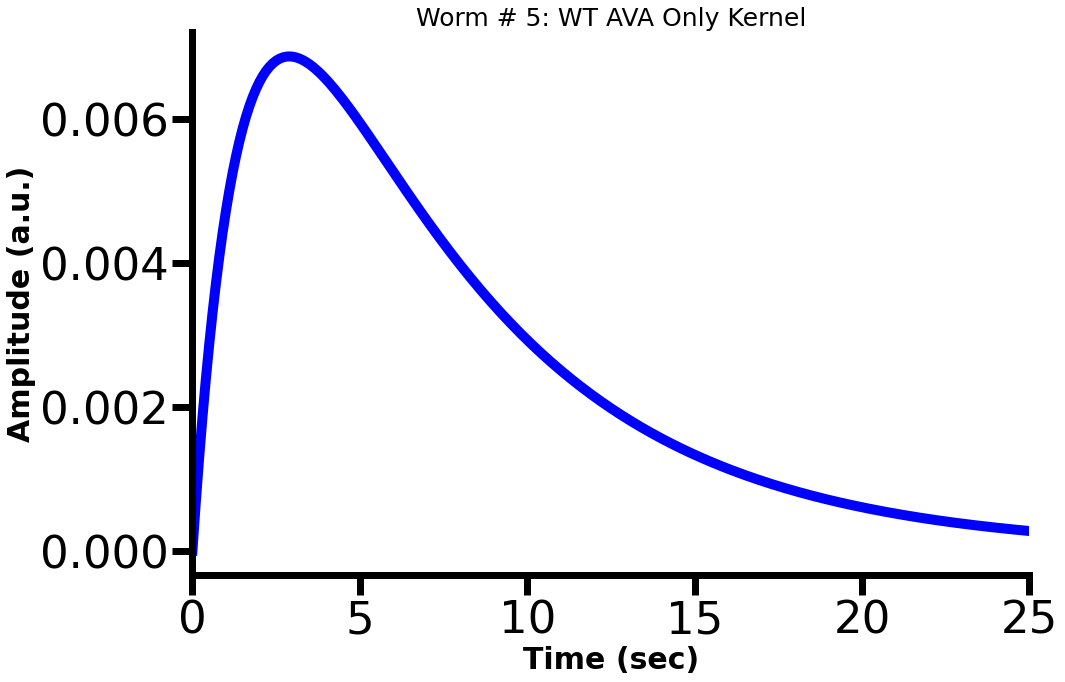

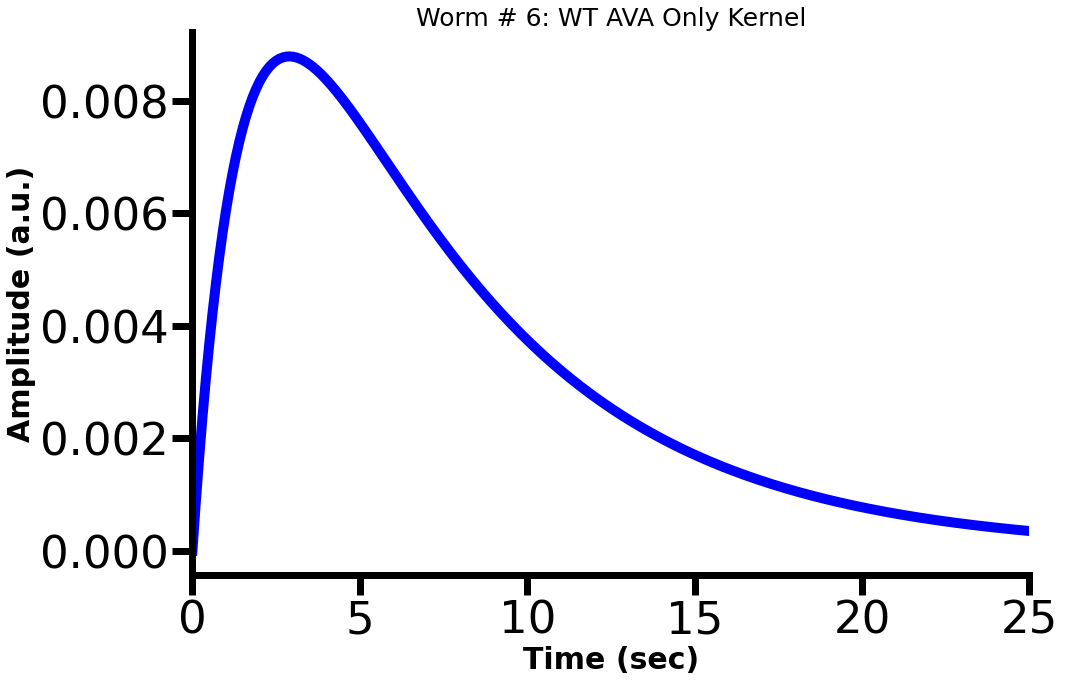

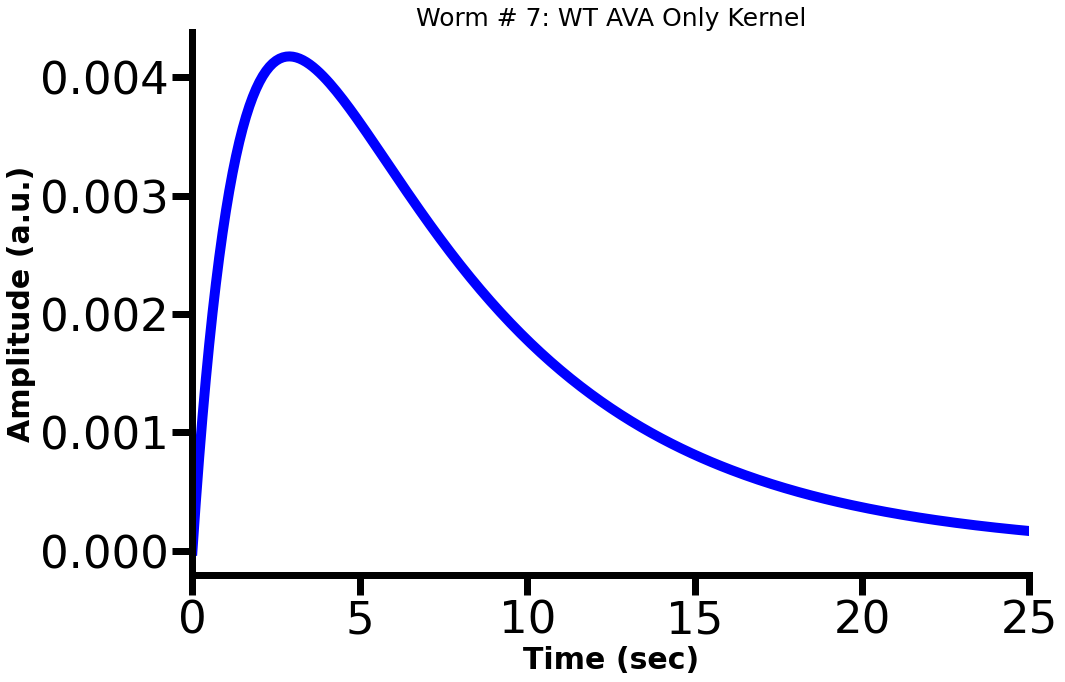

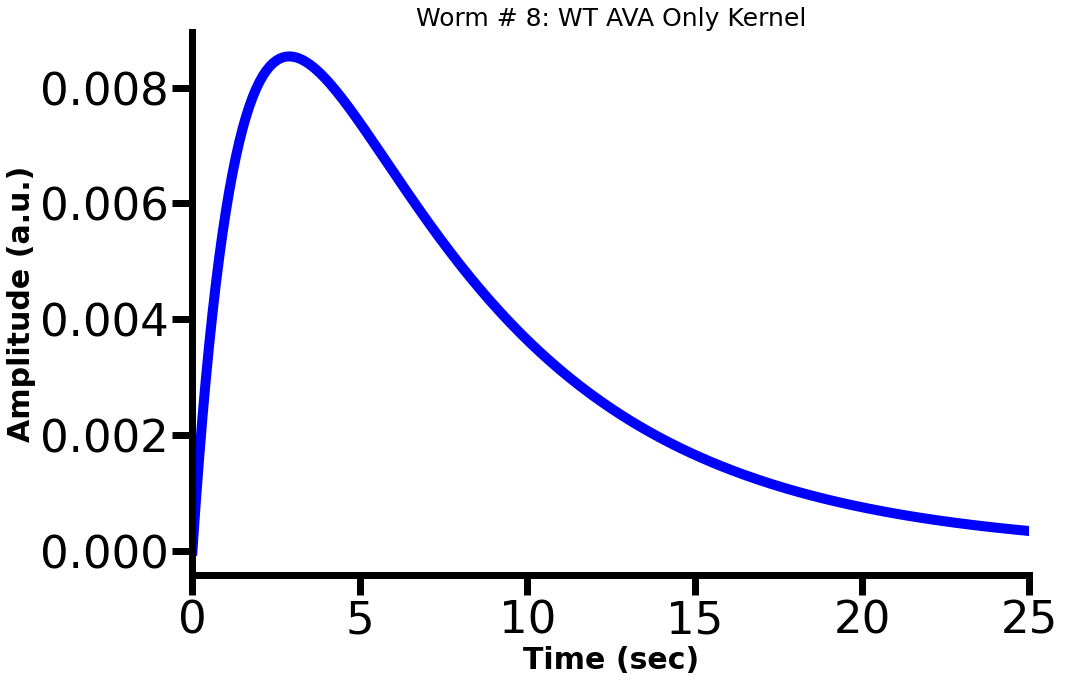

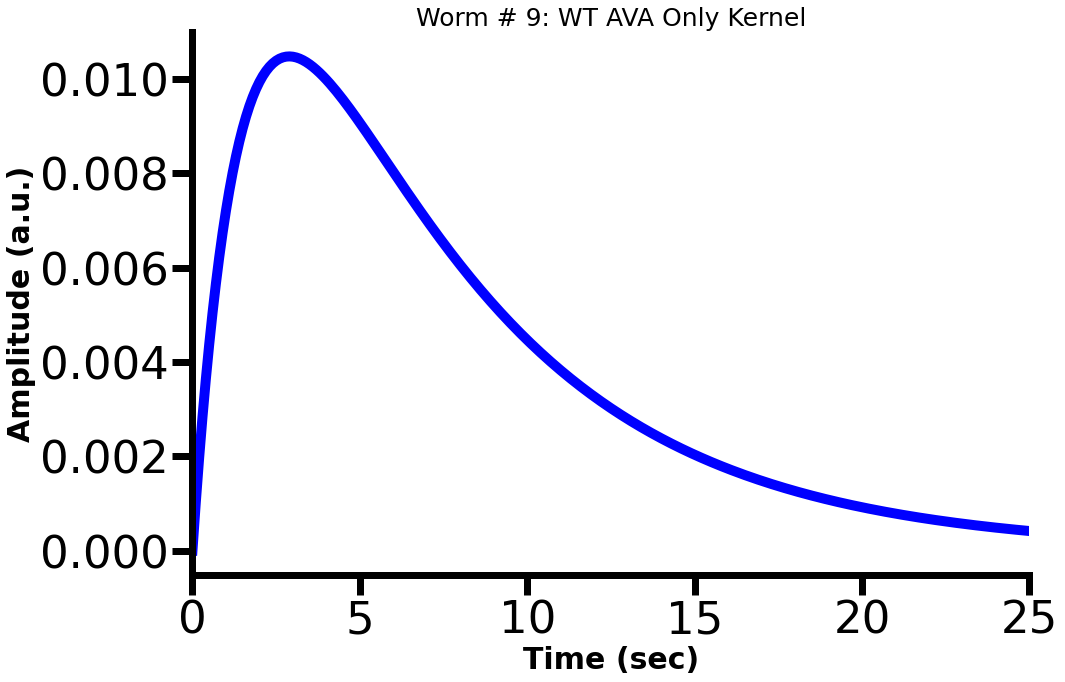

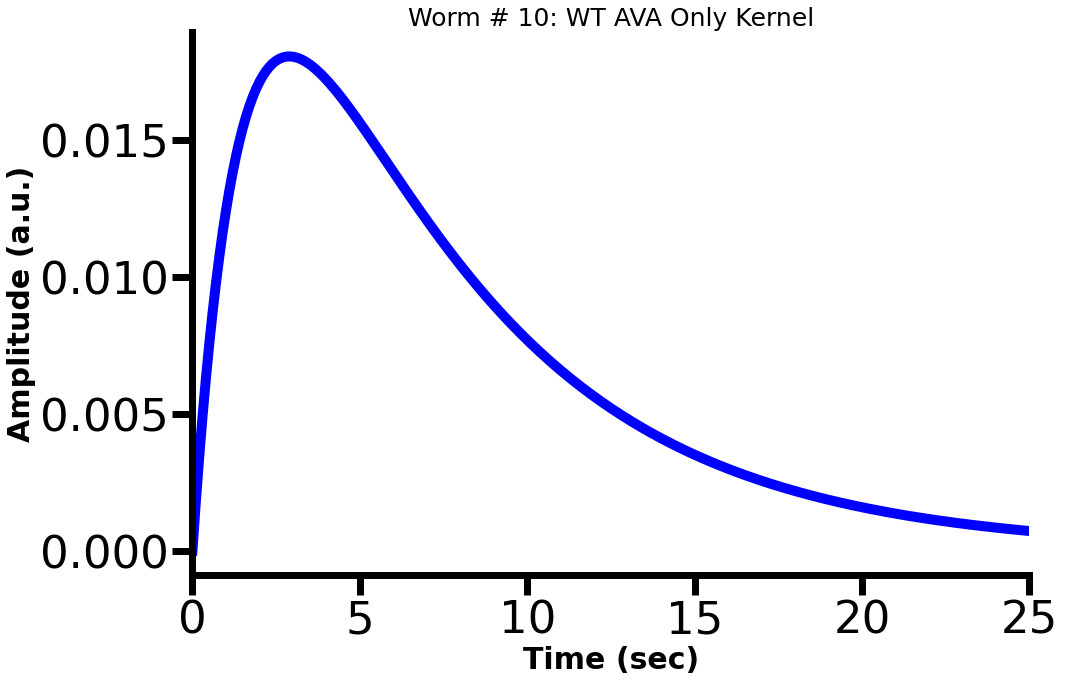

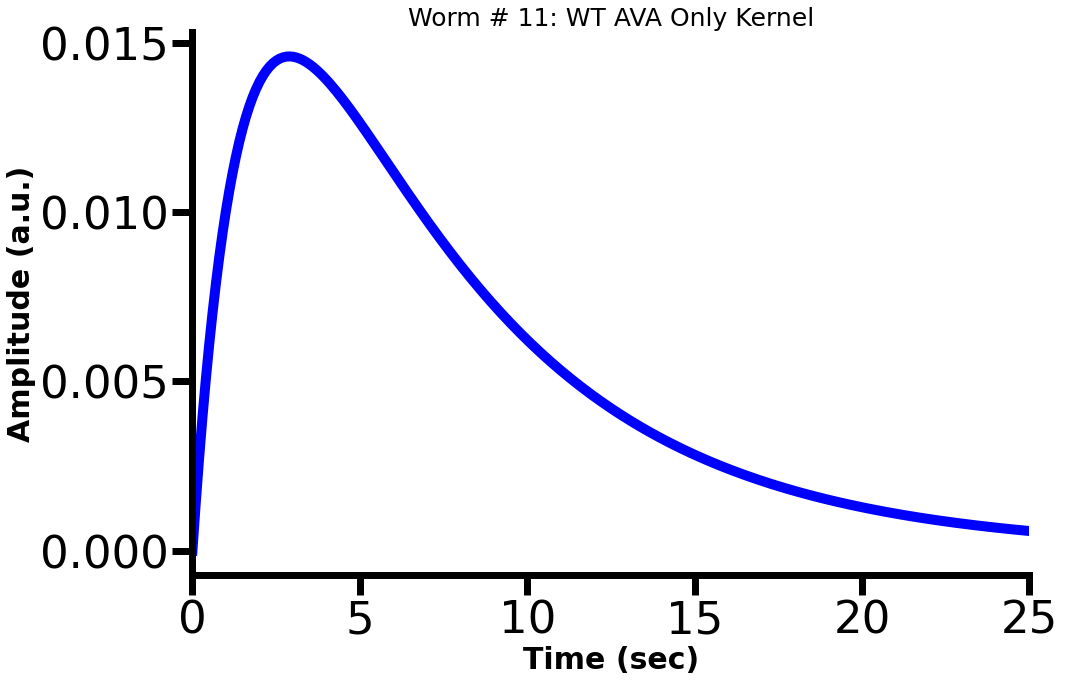

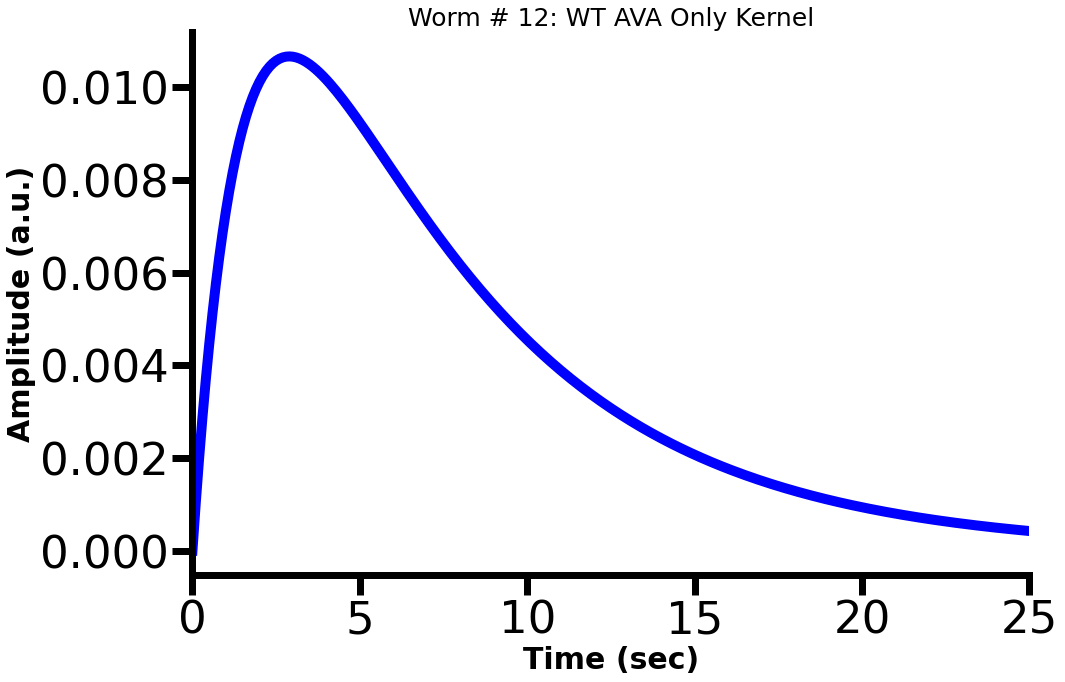

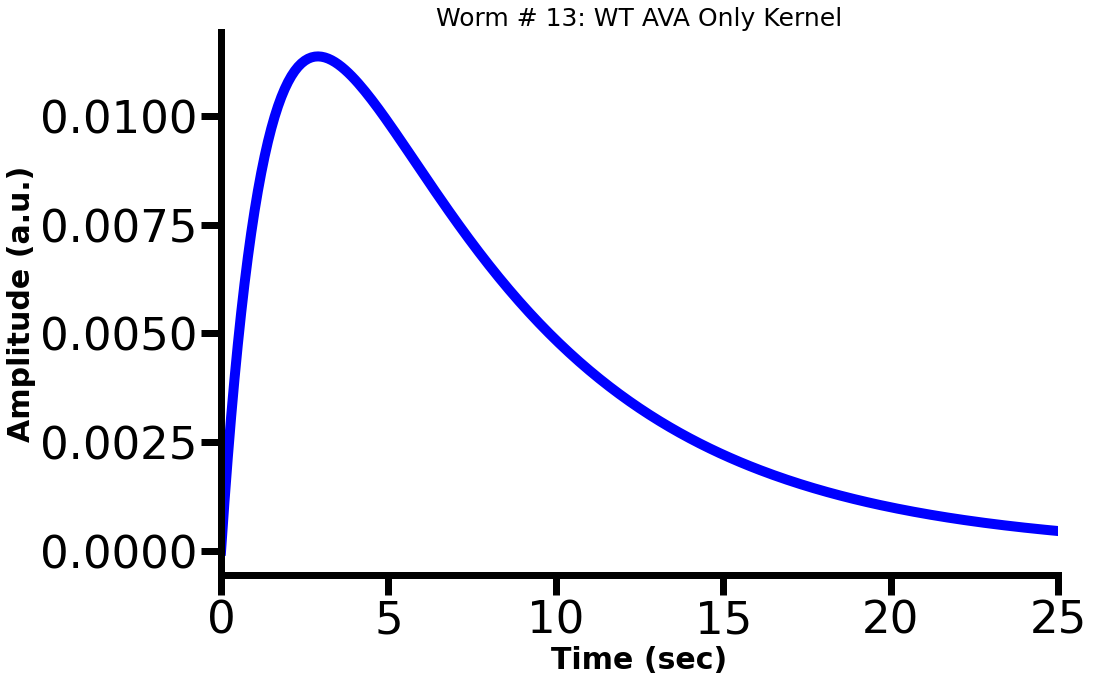

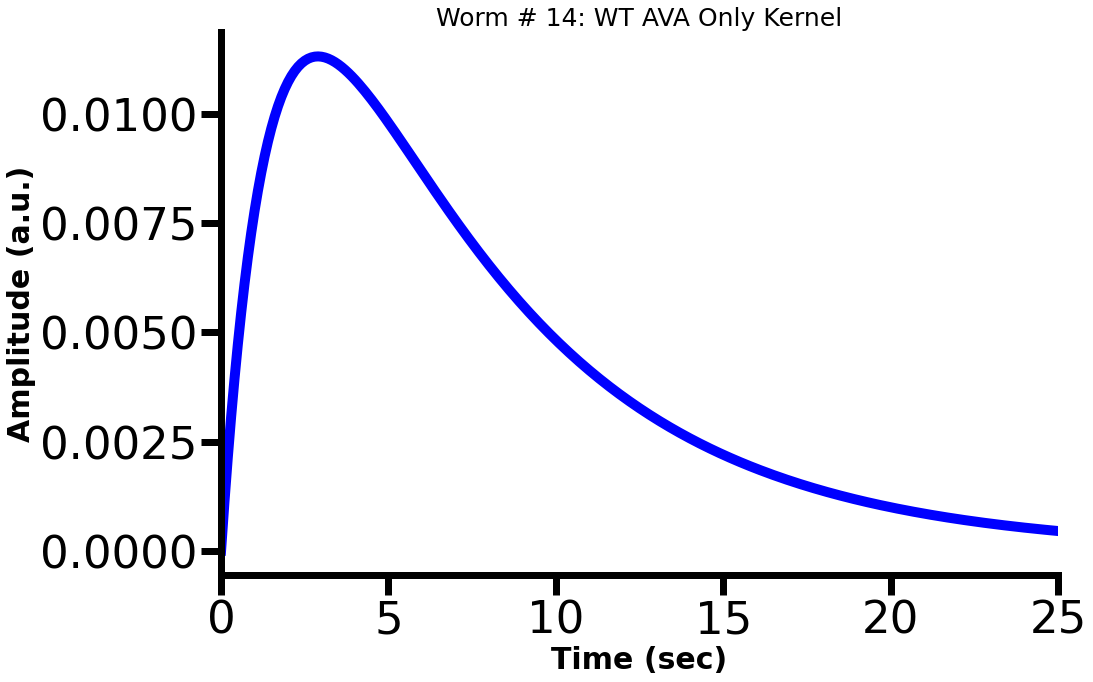

In [127]:
## - Plotting Kernels - ##
# Will show just odor+red light exps for simplicity (corresponds to above model plots)

# Worm #2 is what's shown in the paper figures. 

t = np.arange(0, 250) #length of kernel window

worm_num = WT_worm_num
title_name = 'WT AVA Only'
amps = WT_AVA_both_amps
alpha1s = WT_AVA_med_alpha1_both
# this is the median value, don't need to loop (below), if you want individual values use WT_AVA_both_alpha1[i]
alpha2s = WT_AVA_med_alpha2_both
# this is the median value, don't need to loop (below), if you want individual values use WT_AVA_both_alpha2[i]

# Kernel time window is 250 frames (25 seconds) -- much more straightforward than above lol 
timeplot = []
for p in range(250):
    temp = p/10
    timeplot.append(temp)

for i in range(worm_num):
    kernel = amps[i] * (np.exp(-alpha1s*t) - np.exp(-alpha2s*t)) #see comment above for alphas
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 7
    ax.set_title('Worm # '+str(i) + ': '+ title_name + ' Kernel', fontsize=25)
    ax.plot(timeplot, kernel, color='blue', linewidth=10, alpha=1, label = 'AVA')
    ax.set_ylabel('Amplitude (a.u.)', fontsize=30, weight='bold')
    ax.set_xlabel('Time (sec)', fontsize=30, weight='bold')
    ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
    ax.set_xlim([0,25])
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    #plt.savefig(title_name + '.svg')

